In [65]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append("/Users/ryan/Desktop/work/school intern/Energy Intern /eco-tools/") #path to PI CLient

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import requests
import seaborn as sns 
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
#print(mnv.version)  # Last updated for mnv v2.0.1
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib import style
style.use('fivethirtyeight')

# get value from pi

In [3]:
#data_helper.py

# if its class
##import data_helper
##a = da
# if its functions
##from data_helper import *

# slice_data function
##data_helper.slice_data("")

In [67]:
pc = pi_client(root='readonly') #assgin values

In [68]:
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu") #GBSF_ChilledWater_Demand_kBtu
# use electricity data 
points

['GBSF_Electricity_Demand_kBtu']

In [69]:
start = "2017-07-05" 
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'

In [7]:
df = pc.get_stream_by_point(points,  start = start, 
                            end = end,calculation=calculation,
                            interval=interval)
df.shape

Grabbing WebIDs ...
WebID collection complete!
13:08:43: Sending API request... Chunk 1 of 1
13:08:44: Response recieved for 1 tags! (0.87)


(18011, 1)

In [8]:
df = df[np.isfinite(df).all(1)]

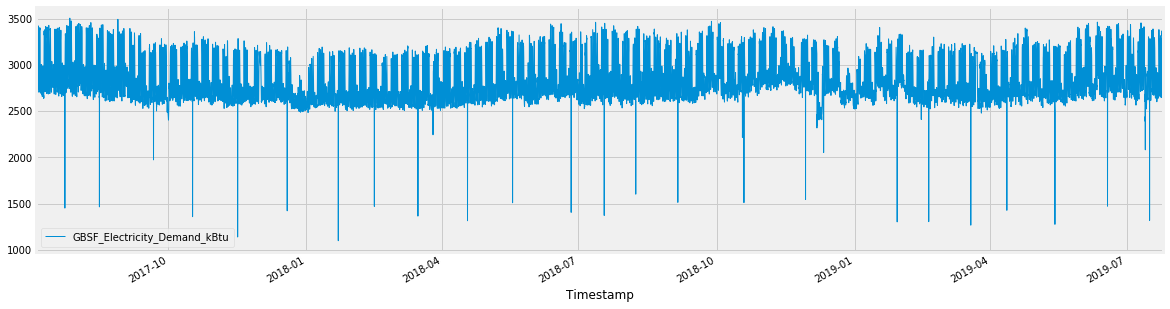

In [10]:
df.plot(figsize = (18,5),linewidth = 1)
#plt.axhline(y = -4559.555552373463,color="red")
#plt.axhline(y = 9763.775384346645,color="red") #3sd method

# 1.  z-score and 3 sd = 95%

In [12]:
def detect_outlier(df):
    outliers=[]
    threshold=3
    mean_1 = np.mean(df)
    std_1 =np.std(df)
    
    for y in df:
        z_score = (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
            
    return outliers

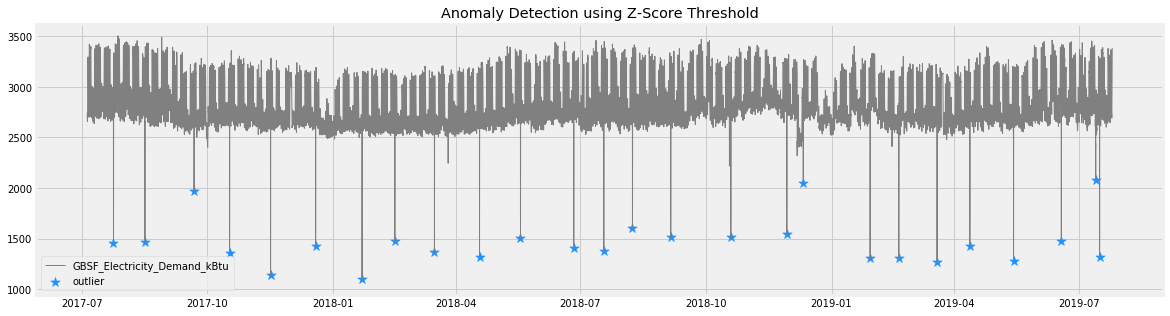

In [13]:
# detect outliers based on 3 sd away from emean
def detect_outlier(dataframe, threshold=3):
   dataframe = pd.DataFrame(dataframe)
   mean_1 = dataframe.mean()[0]
   std_1 = dataframe.std()[0]
   dataframe['zscore'] = (dataframe.values - mean_1)/std_1
   dataframe['outlier'] = np.nan
   dataframe.loc[(np.abs(dataframe.zscore) > threshold), 'outlier'] = dataframe.iloc[:,0].loc[(np.abs(dataframe.zscore) > threshold)]
   dataframe.drop(columns='zscore', inplace=True)
   return dataframe

outlier_datapoints = detect_outlier(df.GBSF_Electricity_Demand_kBtu)
# plot size 
plt.figure(figsize=(18,5))
# plot all electricity data, linewidth = 1, color = gray
plt.plot(outlier_datapoints.index, outlier_datapoints.GBSF_Electricity_Demand_kBtu,
        linewidth=1, color='gray')
# plot outliers data, them must have the same index to plot sucessfully, color = blue, maker = *, size = 100
plt.scatter(outlier_datapoints.index, outlier_datapoints.outlier, color='dodgerblue', marker='*', s=100)
plt.title("Anomaly Detection using Z-Score Threshold")
# set up at the leftbottom 
plt.legend()
plt.show()

In [31]:
outlier_datapoints = detect_outlier(df["GBSF_Electricity_Demand_kBtu"])
print(outlier_datapoints)

[1453.3170471191406, 1466.1823455810547, 1973.781532796224, 1360.4095428466796, 1140.9758306545682, 1423.6978698730468, 1100.9191975911458, 1471.6505564371744, 1366.7412007649739, 1316.5795237223308, 1510.3328704833984, 1406.8805694580078, 1373.7094116210938, 1603.5392812093098, 1514.8966013590496, 1512.1701253255208, 1546.9441986083984, 2052.4293416341147, 1303.883280436198, 1306.8043314615886, 1268.9043477376301, 1429.2364298502605, 1277.835205078125, 1473.9635416666667]


# 2. box plot 

<Figure size 1296x360 with 0 Axes>

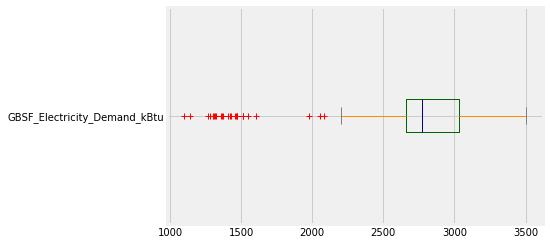

In [15]:
plt.figure(figsize=(18,5))
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange','medians': 'DarkBlue', 'caps': 'Gray'}
df.plot.box(vert=False,color=color, sym='r+')
# 25%, 75%

# 3. density plot

<Figure size 1296x360 with 0 Axes>

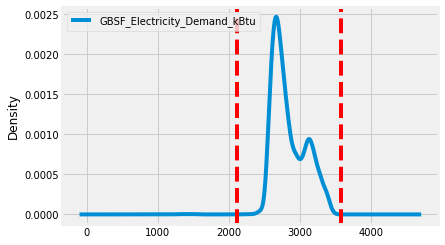

In [16]:
plt.figure(figsize=(18,5))
df.plot.kde()
plt.axvline(2107.71747317844, linestyle = '--', color = 'r')
plt.axvline(3577.4252127075197, linestyle = '--', color = 'r')

# 4. percentile

In [70]:
sorted(df)

['GBSF_Electricity_Demand_kBtu']

In [71]:
q1,q3 = df['GBSF_Electricity_Demand_kBtu'].quantile([.25,.75])

In [72]:
iqr = q3 - q1

In [73]:
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

In [74]:
upper_bound 

3583.3199134826664

In [75]:
lower_bound

2104.9897600809727

In [76]:
np.sum(df['GBSF_Electricity_Demand_kBtu'] < 0)

0

In [77]:
mask = (df['GBSF_Electricity_Demand_kBtu'] < 2107.71747317844 )| (df['GBSF_Electricity_Demand_kBtu'] > 3577.4252127075197 )

In [80]:
min(df['GBSF_Electricity_Demand_kBtu'])

1100.9191975911458

In [81]:
anormaly = df.loc[mask]

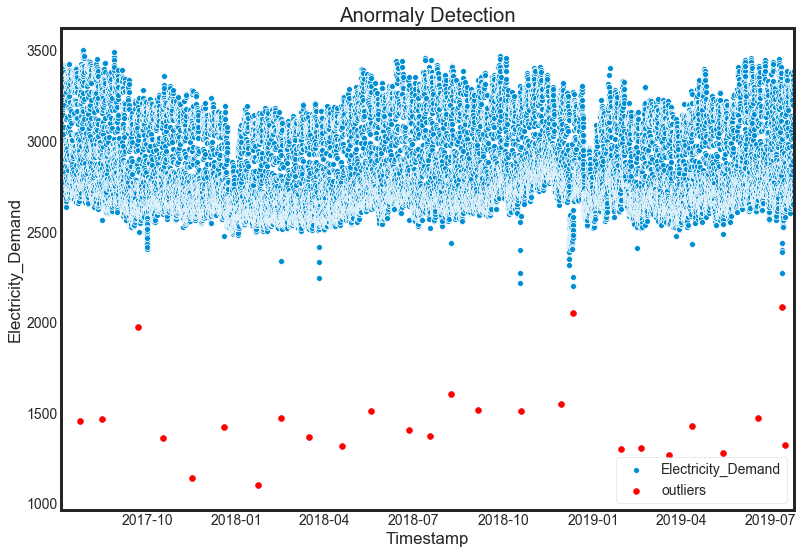

In [96]:
# plot, and if its lower than 25% && higher than 75%, mark them red
sns.set_style("white")
plt.figure(figsize=(18,5))
plt.xlim(df.index[0], df.index[-1])
plt.gcf().set_size_inches(11.7, 8.27)
ax = sns.scatterplot(x=df.index, y="GBSF_Electricity_Demand_kBtu", data=df)
ax.set_title('Anormaly Detection')
ax.set_ylabel('Electricity_Demand')
plt.scatter(x= anormaly[mask].index, 
            y = anormaly[mask]['GBSF_Electricity_Demand_kBtu'], 
            color= 'r')
plt.legend(labels=['Electricity_Demand','outliers'])

# 5. k means for clusting

In [29]:
df = df[np.isfinite(df).all(1)]

[[ 2975.5         2820.45158822]
 [14952.          2842.81258628]
 [ 8945.5         2862.15278344]]
[5963 6015 5987]


<Figure size 1296x360 with 0 Axes>

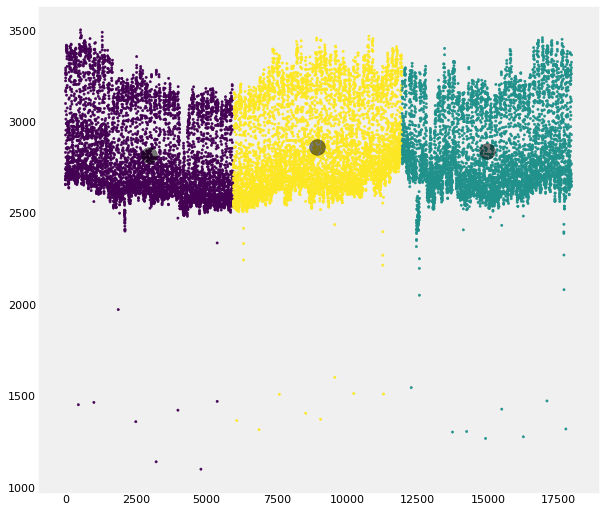

In [31]:
x = range(len(df.index))
y = df["GBSF_Electricity_Demand_kBtu"]
data = np.column_stack([x,y])
plt.figure(figsize=(18,5))
kmeans = KMeans(n_clusters=3)
data_transformed = kmeans.fit(data)
y_kmeans = kmeans.predict(data)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=4, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.grid()

print(centers)
print(np.bincount(kmeans.labels_))

In [32]:
type(data)

numpy.ndarray

In [33]:
# FIND THE PROPER number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)

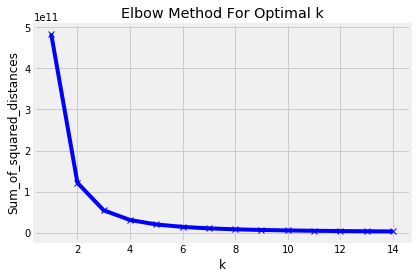

In [34]:
# k is 4, which is a point where the line start to be flat
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# 6. agglomerative hierarchical clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')  
cluster.fit_predict(df) 

array([0, 0, 0, ..., 2, 2, 2])

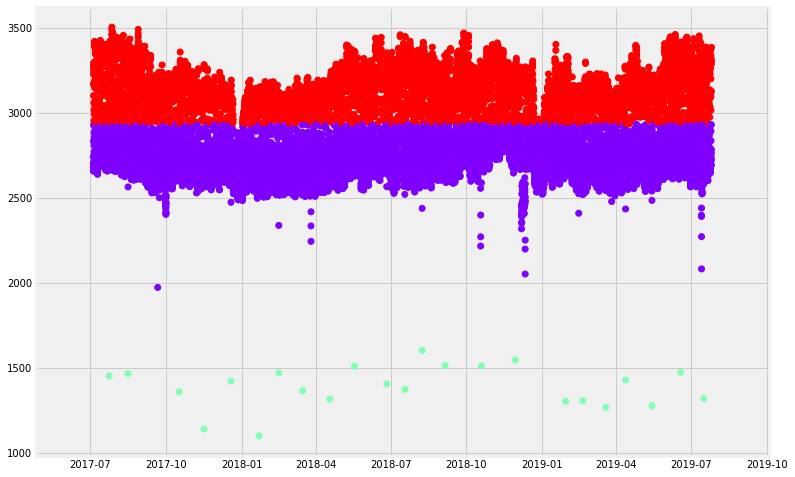

In [16]:
plt.scatter(df.index,df[0:], c=cluster.labels_,linewidth = 1, cmap='rainbow') 
plt.gcf().set_size_inches(11.7, 8.27)

In [17]:
points = pc.search_by_point("aitit4045") # get outside air tempeture
points

['aiTIT4045']

In [18]:
start = "2017-07-05" 
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'

In [19]:
tp = pc.get_stream_by_point(points,  start = start, 
                            end = end,calculation=calculation,
                            interval=interval)
tp.shape

Grabbing WebIDs ...
WebID collection complete!
13:10:10: Sending API request... Chunk 1 of 1
13:10:11: Response recieved for 1 tags! (0.92)


(18011, 1)

In [20]:
result = pd.merge(df, tp, on='Timestamp')

In [21]:
result

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2017-07-05 00:00:00,2742.115666,67.199602
2017-07-05 01:00:00,2703.342263,66.549455
2017-07-05 02:00:00,2683.433364,65.147544
2017-07-05 03:00:00,2684.103522,63.976632
2017-07-05 04:00:00,2659.619794,61.242740
2017-07-05 05:00:00,2657.369491,60.156010
2017-07-05 06:00:00,2691.471765,61.455913
2017-07-05 07:00:00,2833.344177,65.848933
2017-07-05 08:00:00,2928.925806,69.644673


In [47]:
result['label'] = cluster.labels_

In [48]:
unique_cluster_labels_ = np.unique(cluster.labels_.tolist())

In [49]:
outliers = []

for i in unique_cluster_labels_:
    subresult = result.loc[result["label"] == i]
    #threthldold
    #print(subresult.shape)
    #q1, q3= np.percentile(subresult["aiTIT4045"].tolist(),[25,75])

    q1,q3 = result.loc[result['label'] == i].quantile([.25,.75])["aiTIT4045"].unique()
    print("q1: " + str(q1))
    print("q2: " + str(q3))
    print(i)
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr) 
    print("lower: "+str(lower_bound))
    print("upper: " + str(upper_bound))
    
    mask1 = subresult["aiTIT4045"]<lower_bound
    mask2 = subresult["aiTIT4045"] > upper_bound
    mask = mask1 | mask2
    print(subresult.loc[mask].shape)
    outliers.append(subresult.loc[mask])
    print("\n\n")
    #for j in subresult["aiTIT4045"].tolist():
     #   if j < lower_bound or j > upper_bound:
      #  
       #     outliers.append(j)
    #print(outliers)    
outliersplot = pd.concat(outliers)

q1: 52.09965950329977
q2: 67.87069218692966
0
lower: 28.443110477854933
upper: 91.52724121237449
(268, 3)



q1: 50.546902978540544
q2: 59.93399560956457
1
lower: 36.4662640320045
upper: 74.0146345561006
(1, 3)



q1: 62.09683639410596
q2: 85.51378052819129
2
lower: 26.971420192977952
upper: 120.6391967293193
(0, 3)





In [50]:
outliersplot["label"].unique()

array([0, 1])

In [56]:
outliersplot.groupby(by = "label")

In [52]:
# see how many data points in each clusters
np.bincount(cluster.labels_)

array([13278,    23,  4664])

In [64]:
subresult

,GBSF_Electricity_Demand_kBtu,aiTIT4045,label
Timestamp,,,
2017-07-05 09:00:00,3101.260468,73.454433,2
2017-07-05 10:00:00,3172.594159,77.773465,2
2017-07-05 11:00:00,3225.338729,82.469200,2
2017-07-05 12:00:00,3283.581494,86.745086,2
2017-07-05 13:00:00,3265.138552,90.335850,2
2017-07-05 14:00:00,3271.150136,87.051675,2
2017-07-05 15:00:00,3241.205601,88.601903,2
2017-07-05 16:00:00,3295.395679,94.438616,2
2017-07-05 17:00:00,3258.663045,96.336959,2


In [88]:
result['label'].unique()

array([0, 2, 1])

In [89]:
result.head()

,GBSF_Electricity_Demand_kBtu,aiTIT4045,label
Timestamp,,,
2017-07-05 00:00:00,2742.115666,67.199602,0
2017-07-05 01:00:00,2703.342263,66.549455,0
2017-07-05 02:00:00,2683.433364,65.147544,0
2017-07-05 03:00:00,2684.103522,63.976632,0
2017-07-05 04:00:00,2659.619794,61.242740,0


In [90]:
subresult['label'].unique()

array([2])

In [91]:
unique_cluster_labels_ = np.unique(cluster.labels_.tolist())

In [92]:
result.loc[result["label"] == 3]#.isna().count()

,GBSF_Electricity_Demand_kBtu,aiTIT4045,label
Timestamp,,,


In [93]:
result.loc[result["label"] == 2].isna().count()

GBSF_Electricity_Demand_kBtu    3654
aiTIT4045                       3654
label                           3654
dtype: int64

In [94]:
result.loc[result['label'] == 3].quantile([.25,.75])


,GBSF_Electricity_Demand_kBtu,aiTIT4045,label
0.25,NaN,NaN,NaN
0.75,NaN,NaN,NaN


In [95]:
q1,q3 = result.loc[result['label'] == 0].quantile([.25,.75])["aiTIT4045"].unique()
print(q1,q3)

52.20132130142996 68.10799776012198


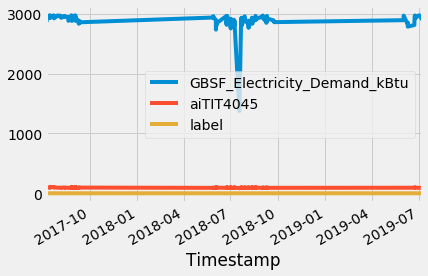

In [65]:
outliersplot.plot()

In [53]:
subresult["aiTIT4045"].tolist()

[66.54945492283444,
 65.1475442774182,
 63.97663175737535,
 61.24273967025657,
 60.15601038272008,
 61.45591287738695,
 65.84893339730623,
 64.57346673631021,
 64.4735398373592,
 62.80280612457167,
 62.69895101566153,
 64.18903374098423,
 65.09854891994425,
 63.93018851909982,
 63.25677852811045,
 65.14226505543911,
 71.40823093134999,
 66.03729581207709,
 64.92710785555343,
 64.9845116534516,
 65.2427221297518,
 65.38763815402113,
 71.48181175546972,
 63.782477724179685,
 63.78438444448107,
 62.84114268705796,
 62.151984207927484,
 62.610662065559225,
 68.41289561571077,
 65.98059960587307,
 64.37914263159007,
 62.78397667489995,
 63.445653135601255,
 63.2700817799191,
 62.97875981227933,
 65.16648126756427,
 70.79797800506375,
 64.4947309090737,
 63.27410836558358,
 63.26035963494158,
 64.78927429767859,
 70.22886423708246,
 64.00022449759037,
 62.452892931015306,
 62.41211521382914,
 61.23953167387275,
 62.75612567526226,
 64.72108939583805,
 62.440413678386165,
 61.716461533381185,

In [19]:
newdf = result[result['label'] == 1]

In [20]:
sortednewdf = sorted(newdf.iloc[:,1])

In [21]:
q1, q3= np.percentile(sortednewdf,[25,75])
iqr = q3 - q1
lower_bound = q1 -(3 * iqr) 
upper_bound = q3 +(3 * iqr) 

In [22]:
np.mean(sortednewdf)

71.60715425310721

In [43]:
print(lower_bound)
print(upper_bound)

62.66887427400448
114.51230930707149


In [85]:
def getbound(df):
    sortdf = sorted(df.iloc[:,1])
    q1 = np.percentile(sortdf,25)
    q3 = np.percentile(sortdf,75)
    iqr = q3 - q1
    lower_bound = q1 -(3 * iqr)
    upper_bound = q3 +(3 * iqr) 
    return lower_bound,upper_bound

In [86]:
newdf2= result[result['label'] == 2]
newdf3= result[result['label'] == 3]
newdf0= result[result['label'] == 0]

In [90]:
print(getbound(newdf2))
print(getbound(newdf3))
print(getbound(newdf0))

(58.51390101917738, 96.5259621604111)
(79.67611350527785, 118.79635482956147)
(nan, nan)


# 7. ARIMA prediction ,  short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

# Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)



In [22]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pmdarima import auto_arima #: to get p,d,q
from statsmodels.tsa.arima_model import ARIMA
#import plotly.plotly as ply
from sklearn.model_selection import train_test_split

result = adfuller(df.iloc[:,0].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# when p is less than 0.05, no d 

ADF Statistic: -14.778172
p-value: 0.000000


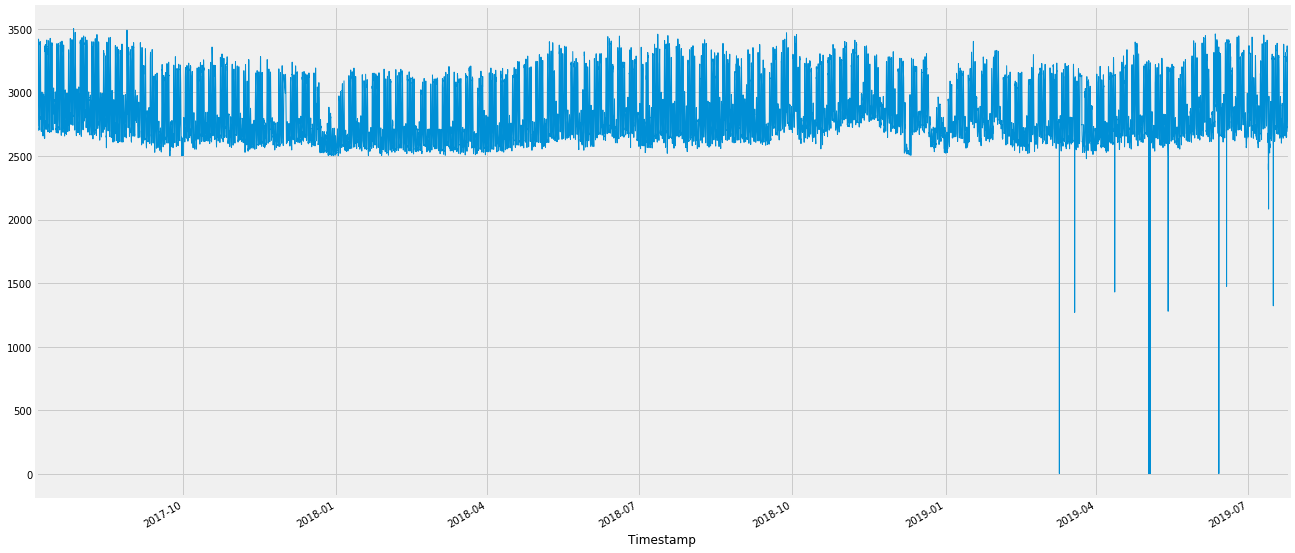

In [54]:
# clean the first half of the GBSF electricity data to be used in training a model (ARIMA, LSTM, RandomForest). 
# For clustering, we don’t really “train” any model so this cleaning doesn’t need to happen.

df_hour = df.resample('1h').sum()

#split the data into half
df_train = df_hour.loc[:,'GBSF_Electricity_Demand_kBtu'][0:int(len(df_hour.GBSF_Electricity_Demand_kBtu)*4/5)]

 
# clean and trained data
df_train = df_train.drop(df_train[df_train.values<2500].index, axis=0)
df_valid = df_hour.loc[:,'GBSF_Electricity_Demand_kBtu'][int(len(df_hour.GBSF_Electricity_Demand_kBtu)*4/5):]
 
# merge them together and show them
df_merge = pd.concat([df_train, df_valid], axis = 0)
df_merge.sort_index(ascending=True)

# plot the data
df_merge.plot(figsize=(20,10), linewidth=1)




In [24]:
type(df_train)

pandas.core.series.Series

In [25]:
# bulit up the model suing auto_arima
ari_model = auto_arima(df_train, trace=True, error_action='ignore', suppress_warnings=True)

ari_model = ari_model.fit(df_train)
ari_model.summary()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=145211.312, BIC=145256.710, Fit time=8.475 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=157917.496, BIC=157932.628, Fit time=0.328 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=148319.287, BIC=148341.986, Fit time=0.608 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=151998.749, BIC=152021.448, Fit time=1.870 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=148162.402, BIC=148200.234, Fit time=1.821 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=148200.815, BIC=148238.647, Fit time=3.154 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=148233.342, BIC=148263.607, Fit time=1.256 seconds
Fit ARIMA: order=(3, 1, 3) season

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                14277
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -72599.656
Date:                Thu, 25 Jul 2019   AIC                         145211.312
Time:                        13:10:55   BIC                         145256.710
Sample:                             0   HQIC                        145226.411
                              - 14277                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0010      0.013     -0.074      0.941      -0.027       0.025
ar.L1          1.9124      0.002    934.061      0.000       1.908       1.916
ar.L2         -0.9802      0.002   -499.186      0.000      -0.984      -0.976
ma.L1         -1.7266      0.005   -339.742      0.000      -1.737      -1.717
ma.L2          0.7626      0.005    145.086      0.000       0.752       0.773
sigma2      1529.5209      9.646    158.559      0.000    1510.614    1548.427
===================================================================================
Ljung-Box (Q):                     4844.70   Jarque-Bera (JB):             23952.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.59
Prob(H) (two-sided):                  0.05   Kurtosis:                         9.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

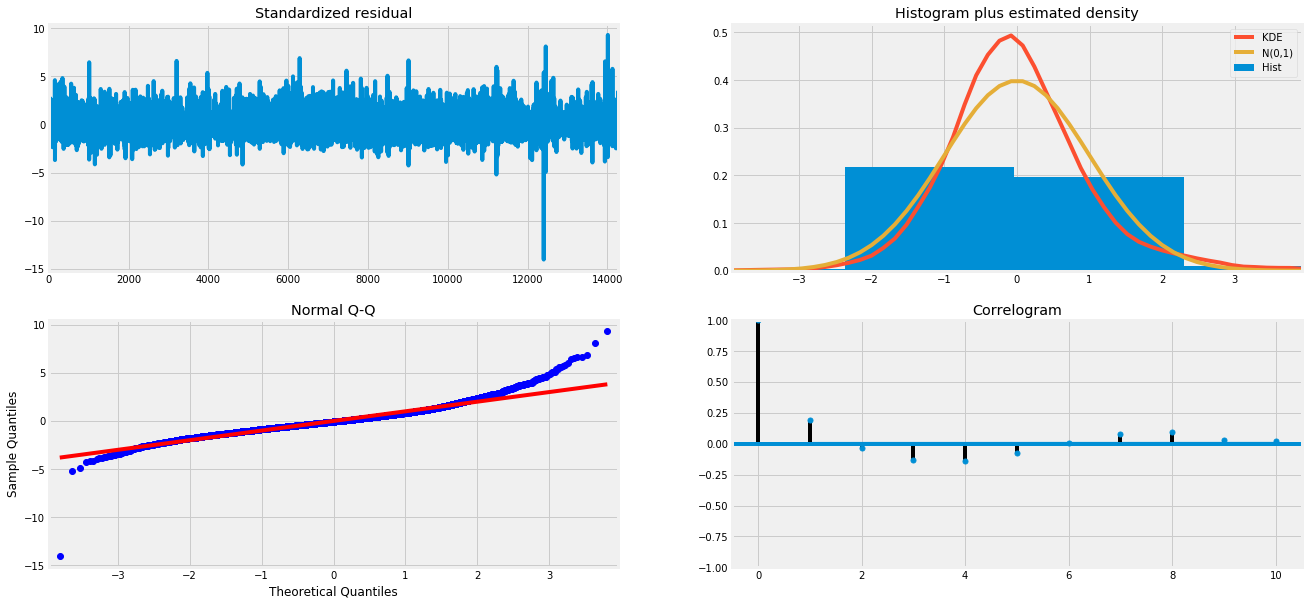

In [26]:
from matplotlib.pyplot import figure

ari_model.plot_diagnostics(figsize = (20,10))
plt.show()

145211.31219482896


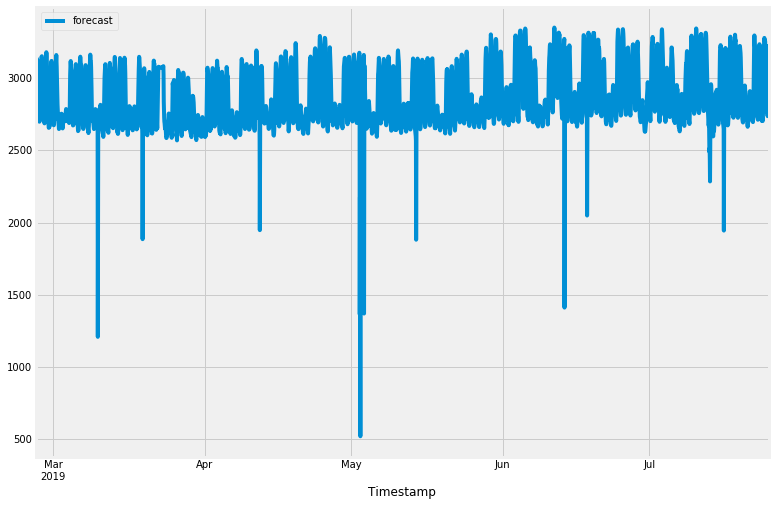

                                   ARIMA Model Results                                    
Dep. Variable:     D.GBSF_Electricity_Demand_kBtu   No. Observations:                 3602
Model:                             ARIMA(2, 1, 2)   Log Likelihood              -23556.794
Method:                                   css-mle   S.D. of innovations            167.369
Date:                            Thu, 25 Jul 2019   AIC                          47125.587
Time:                                    13:11:07   BIC                          47162.723
Sample:                                02-25-2019   HQIC                         47138.821
                                     - 07-25-2019                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.0448      0.015    

In [27]:
## from matplotlib import pyplot
from pandas import DataFrame

# forcast based on the nodel 
ari_forecast = ari_model.predict(len(df_valid),alpha = 0.05)
ari_forecast = pd.DataFrame(ari_forecast,index = df_valid.index,columns=['Prediction'])
print(ari_model.aic())
# choose the smallest AIC numeber, which is (2,1,2)


model = ARIMA(df_valid, order=(2, 1, 2))
model_fit = model.fit(disp=0)
prediction = model_fit.forecast()
model_fit.plot_predict(dynamic=False,plot_insample = False)
plt.gcf().set_size_inches(11.7, 8.27)
#plt.plot(zorder = 2,linewidth = 1)

plt.show()

print(model_fit.summary())


In [28]:
ari_forcasetone= ARIMA(df_valid, order=(2,1,2))
ari_forcasetone_fit = ari_forcasetone.fit(disp=0)

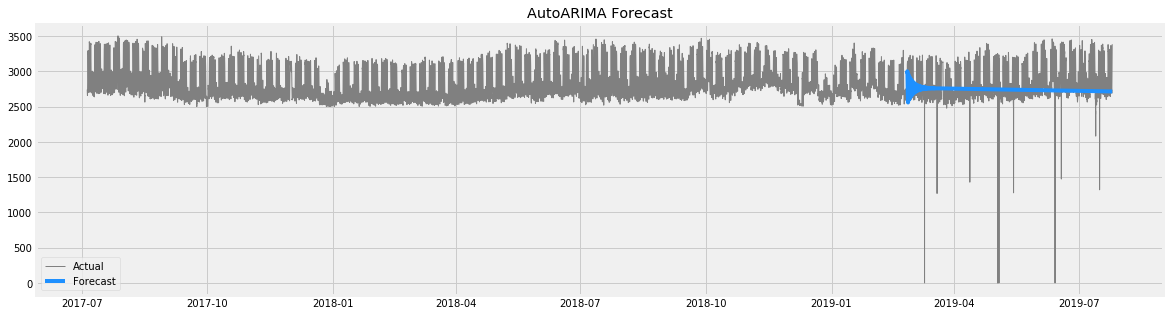

In [29]:
plt.figure(figsize=(18,5))
plt.plot(df_merge.index, df_merge, color='gray', linewidth=1)
plt.plot(df_valid.index, ari_model.predict(n_periods=df_valid.shape[0]), color='dodgerblue')
plt.title("AutoARIMA Forecast")
plt.legend(['Actual','Forecast'])
plt.show()

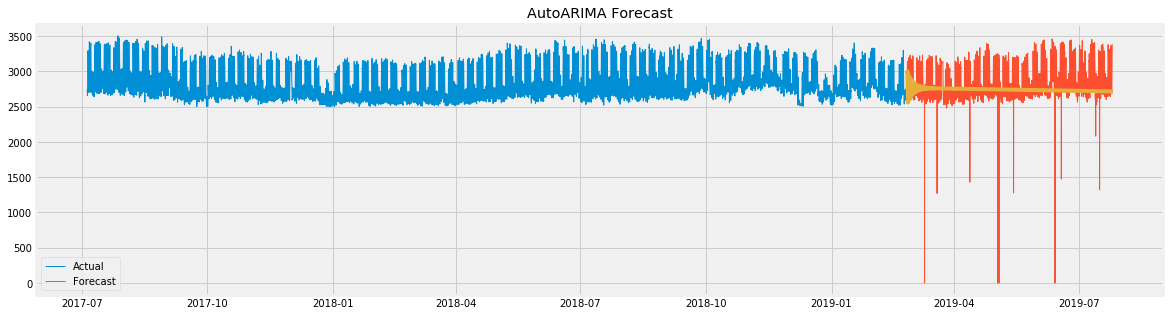

In [30]:
#plot the predictions for validation set
plt.figure(figsize=(18,5))
plt.plot(df_train, label='Train', linewidth=1)
plt.plot(df_valid, label='Valid', linewidth=1)

plt.plot(ari_forecast)
plt.title("AutoARIMA Forecast")
plt.legend(['Actual','Forecast'])
plt.show()


# directly apply p,d,q into the entire dataset and predict the error

In [31]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error


rms = sqrt(mean_squared_error(df_valid,ari_forecast))
print(rms)

290.6455279070456


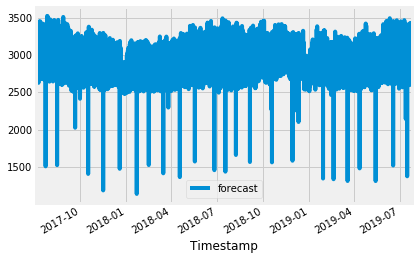

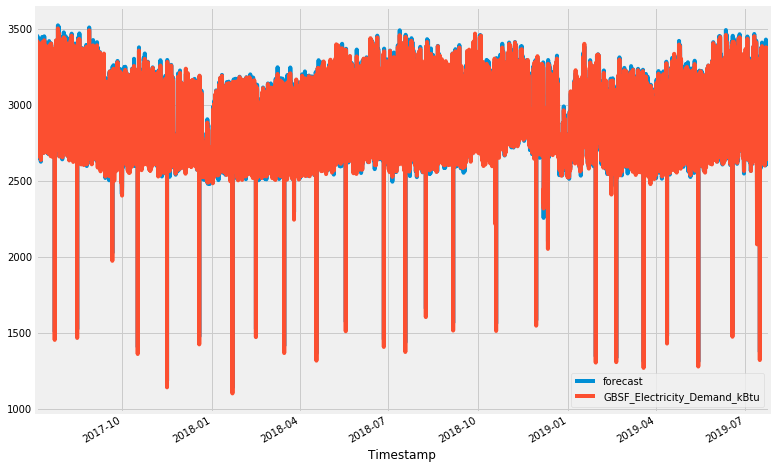

In [36]:
from statsmodels.tsa.arima_model import ARIMA

# fit model, determine the order, p , d , q
model = ARIMA(df.iloc[:,0], order=(2,1,2))
model_fit = model.fit(disp=0)
# make prediction
#yhat = model_fit.predict(len(df), len(df), typ='levels')
#print(yhat)
model_fit.plot_predict(dynamic=False,plot_insample = False)
model_fit.plot_predict(dynamic=False)
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

In [47]:
predicted_value = model_fit.predict(dynamic=False,typ = 'levels')
predicted_value

Timestamp
2017-07-05 01:00:00    2742.144452
2017-07-05 02:00:00    2693.387875
2017-07-05 03:00:00    2672.457939
2017-07-05 04:00:00    2677.274711
2017-07-05 05:00:00    2651.800903
2017-07-05 06:00:00    2653.394587
2017-07-05 07:00:00    2697.852324
2017-07-05 08:00:00    2867.665879
2017-07-05 09:00:00    2975.292103
2017-07-05 10:00:00    3165.922157
2017-07-05 11:00:00    3232.127187
2017-07-05 12:00:00    3273.881182
2017-07-05 13:00:00    3319.777253
2017-07-05 14:00:00    3280.031192
2017-07-05 15:00:00    3268.603966
2017-07-05 16:00:00    3219.909802
2017-07-05 17:00:00    3265.483961
2017-07-05 18:00:00    3215.191820
2017-07-05 19:00:00    3107.602765
2017-07-05 20:00:00    2992.078499
2017-07-05 21:00:00    2948.681468
2017-07-05 22:00:00    2891.726520
2017-07-05 23:00:00    2825.351282
2017-07-06 00:00:00    2761.063408
2017-07-06 01:00:00    2740.563150
2017-07-06 02:00:00    2738.612781
2017-07-06 03:00:00    2720.559510
2017-07-06 04:00:00    2738.704854
2017-07-06

In [45]:
difference_value = model_fit.predict(dynamic=False)

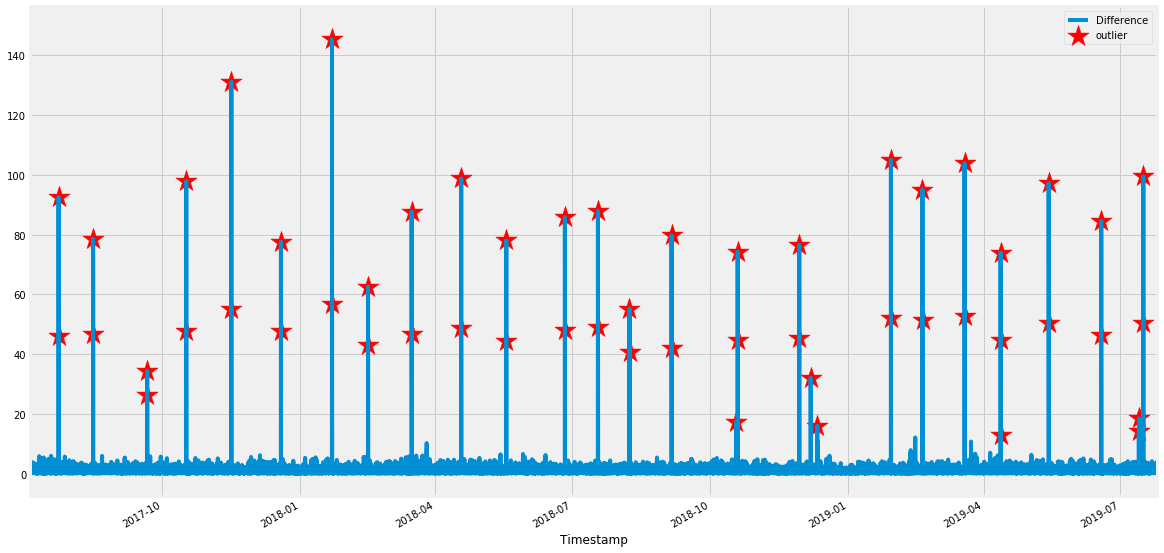

In [61]:
entirepredictdata = pd.concat([df,predicted_value],axis = 1)
entirepredictdata.dropna(inplace = True)
entirepredictdata.columns = ['Actual', 'Modeled']
entirepredictdata.eval('Difference = (Actual - Modeled)/ Actual * 100', inplace=True)
entirepredictdata["Difference"] = entirepredictdata['Difference'].abs()
entirepredictdata.head(3)
entirepredictdata.Difference.plot(figsize = (18, 10))

def detect_outlier(dataframe, threshold=3):
   dataframe = pd.DataFrame(dataframe)
   mean_1 = dataframe.mean()[0]
   std_1 = dataframe.std()[0]
   dataframe['zscore'] = (dataframe.values - mean_1)/std_1
   dataframe['outlier'] = np.nan
   dataframe.loc[(np.abs(dataframe.zscore) > threshold), 'outlier'] = dataframe.iloc[:,0].loc[(np.abs(dataframe.zscore) > threshold)]
   dataframe.drop(columns='zscore', inplace=True)
   return dataframe

outlier_data = detect_outlier(entirepredictdata["Difference"])

plt.scatter(outlier_data.index, outlier_data.outlier, color='red', marker='*', s=500)

plt.legend()
plt.show()


from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
 
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

model_fit.save('model.pkl')

lower_bound: -178.060818 and upper_bound: 174.283120


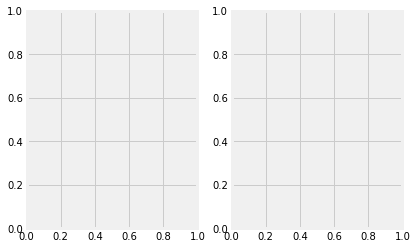

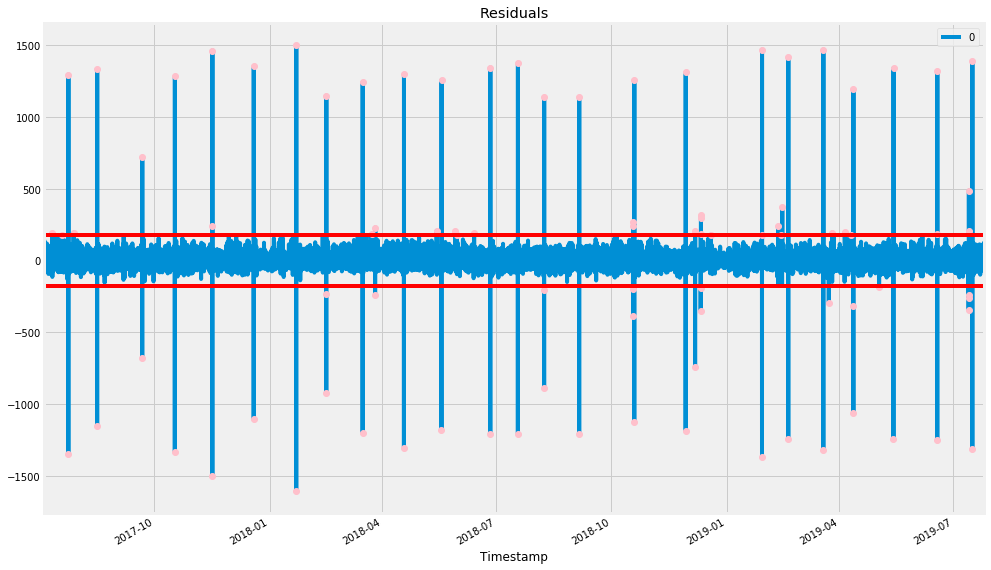

DatetimeIndex(['2017-07-11 09:00:00', '2017-07-19 07:00:00',
               '2017-07-24 06:00:00', '2017-07-24 07:00:00',
               '2017-07-28 10:00:00', '2017-08-16 06:00:00',
               '2017-08-16 07:00:00', '2017-09-21 06:00:00',
               '2017-09-21 07:00:00', '2017-10-17 06:00:00',
               '2017-10-17 07:00:00', '2017-11-16 06:00:00',
               '2017-11-16 07:00:00', '2017-11-16 08:00:00',
               '2017-12-19 06:00:00', '2017-12-19 07:00:00',
               '2018-01-22 06:00:00', '2018-01-22 07:00:00',
               '2018-02-15 05:00:00', '2018-02-15 06:00:00',
               '2018-02-15 07:00:00', '2018-03-16 06:00:00',
               '2018-03-16 07:00:00', '2018-03-23 09:00:00',
               '2018-03-26 06:00:00', '2018-03-26 10:00:00',
               '2018-04-18 06:00:00', '2018-04-18 07:00:00',
               '2018-05-14 09:00:00', '2018-05-18 06:00:00',
               '2018-05-18 07:00:00', '2018-05-29 09:00:00',
               '2018-05-

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

# get the residuals of the orginal and fitted model
residuals = pd.DataFrame(model_fit.resid)
fig, axes = plt.subplots(1,2)
residuals.plot(title="Residuals")

# set standard for the outliers of 3*iqr
a = residuals.iloc[:,0]
q1 = np.percentile(a,25)
q3 = np.percentile(a,75)
iqr = q3 - q1
lower_bound = q1 -(3 * iqr)
upper_bound = q3 +(3 * iqr) 
print("lower_bound: %f" %lower_bound,"and","upper_bound: %f" %upper_bound)

# get all the outliers based on standards
a = (residuals[0]<lower_bound) | (residuals[0]>upper_bound)
residual_outliers = residuals.loc[a]
new_residual_outliers = residual_outliers.values.tolist()


# mark the outliers and show in the graph
for outlier in new_residual_outliers:
    residual_index = residuals.values.tolist().index(outlier)
    date_residual_index = residuals.index[residual_index]
    plt.plot(date_residual_index, outlier, color = 'pink', marker = 'o')
#residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.gcf().set_size_inches(15, 10)
# add residual slit lines

# draw the threshold for the outliers
plt.axhline(y = lower_bound,color="red")
plt.axhline(y = upper_bound,color="red")
plt.show()

#print all the timestamp in regrading to the outliers
print(residual_outliers.index)

ValueError: x and y must be the same size

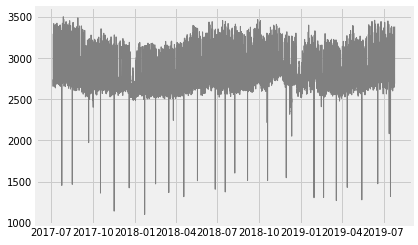

In [34]:
plt.plot(df.index, df['GBSF_Electricity_Demand_kBtu'],
        linewidth=1, color='gray')
# plot outliers data, them must have the same index to plot sucessfully, color = blue, maker = *, size = 100
plt.scatter(new_residual_outliers.index, new_residual_outliers, color='dodgerblue', marker='*', s=100)
plt.title("Anomaly Detection using Z-Score Threshold")
# set up at the leftbottom 
plt.legend()
plt.show()

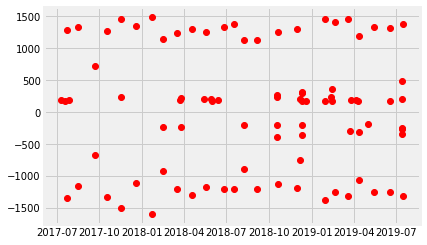

In [35]:
#get all residual outliers in a list: residual_outliers
#plt.plot(r)
for outlier in new_residual_outliers:
    residual_index = residuals.values.tolist().index(outlier)
    date_residual_index = residuals.index[residual_index]
    plt.plot(date_residual_index, outlier, color = 'red', marker = 'o')

In [ ]:
#from IPython.display import display
#display(df.head())

# 8. linear regression model

Text(0.5, 1.0, 'Data Without Outliers')

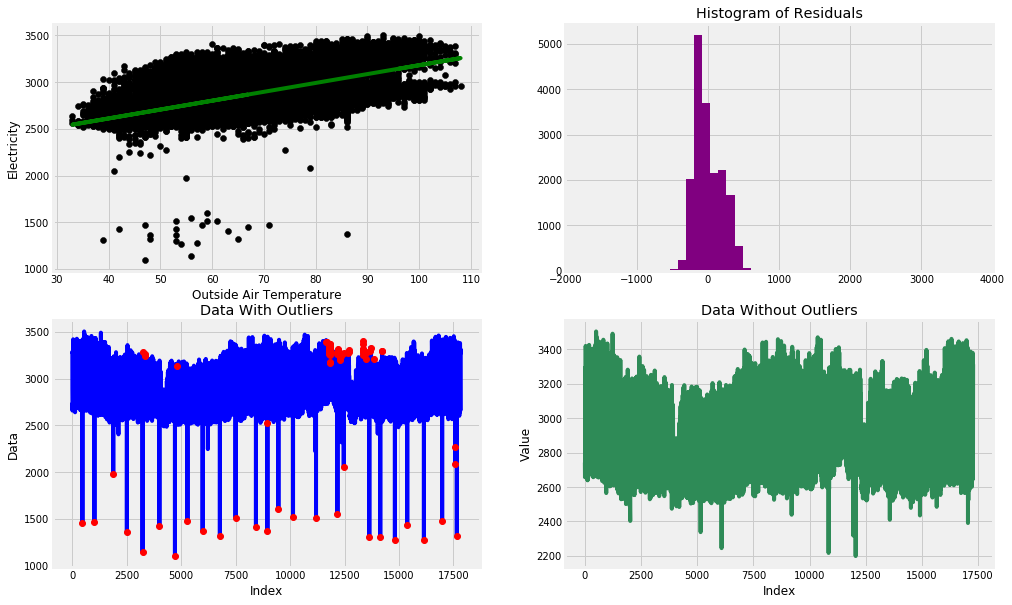

In [32]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression

#pull data - df is chilled water, df2 is outside air temperatue
new_df = pd.merge_asof(df, tp, on = "Timestamp")
#drop any NA values
new_df = new_df.dropna()


#round columns
for col in new_df.columns[1:3]:
   new_df[col] = new_df[col].apply(lambda x: round(x, 0))
#reshape the data so you can use it in the linear reg. model
#here is where you would apply x^2
x =  np.array(new_df.iloc[:, 2]).reshape(-1, 1)
y = np.array(new_df.iloc[:, 1]).reshape(-1, 1)
lnn = LinearRegression().fit(x, y)
#the linear model's fitted predictions
preds = lnn.intercept_ + lnn.coef_ * x
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
#the residuals: actual chilled water - predicted
residuals = (y - preds).reshape(-1, 1)
upper_bound = np.mean(residuals) + 2.5*np.std(residuals)
lower_bound = np.mean(residuals) - 2.5*np.std(residuals)
indexes = []
for i in range(len(residuals)):
   residual = residuals[i]
   if residual > upper_bound or residual < lower_bound:
       indexes.append(i)
y = np.ravel(y).tolist()
outliers = [y[i] for i in indexes]
plt.scatter(x, y, color = "black")
plt.plot(x, preds, color = "green", linewidth=4)
plt.xlabel("Outside Air Temperature")
plt.ylabel("Electricity")
plt.subplot(2, 2, 2)
#plot residuals
plt.hist(residuals, color = "purple", bins = 20)
plt.xlim([-2000, 4000])
plt.title("Histogram of Residuals")
plt.subplot(2, 2, 3)
plt.plot(y, color = "blue")
for i in indexes:
   outlier = y[i]
   plt.plot(i, outlier, color = "red", marker = "o")
plt.xlabel("Index")
plt.ylabel("Data")
plt.title("Data With Outliers")
#retrieve data without outliers
new_data = [x for x in y if x not in outliers]
plt.subplot(2, 2, 4)
plt.plot(new_data, color = "seagreen")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Data Without Outliers")
